# Análisis estático y dinámico

In [1]:
import pefile
from capstone import *

In [4]:
def headerAnalysis(file):
    pe = pefile.PE(file)
    print('SECCIONES \t')
    for section in pe.sections:
        print(section.Name, hex(section.VirtualAddress), hex(section.Misc_VirtualSize), section.SizeOfRawData)
    for entry in pe.DIRECTORY_ENTRY_IMPORT:
        print('LLAMADAS A DLL \t')
        print (entry.dll)
        print('LLAMADAS A FUNCIONES \t')
        for function in entry.imports:
            print ('\t', function.name)
    print("TimeDateStamp : " + pe.FILE_HEADER.dump_dict()['TimeDateStamp']['Value'].split('[')[1][:-1])

In [8]:
def inverseEngineering(file):
    pe = pefile.PE(file)
    # get the address of the program entry point from the program header
    entrypoint = pe.OPTIONAL_HEADER.AddressOfEntryPoint
    # compute memory address where the entry code will be loaded into memory
    entrypoint_address = entrypoint+pe.OPTIONAL_HEADER.ImageBase
    # get the binary code from the PE file object
    binary_code = pe.get_memory_mapped_image()[entrypoint:entrypoint+200]
    # initialize disassembler to disassemble 32 bit x86 binary code
    disassembler = Cs(CS_ARCH_X86, CS_MODE_32)
    # disassemble the code
    for instruction in disassembler.disasm(binary_code, entrypoint_address):
        print ("%s\t%s" %(instruction.mnemonic, instruction.op_str))

In [23]:
def comparationTable3(file):
    malicious_api_calls = {
        "process_hollowing": [
            "CreateProcess", "GetModuleHandle", "GetProcAddress", 
            "VirtualAllocEx", "WriteProcessMemory", "SetThreadContext", 
            "ResumeThread"
        ],
        "create_remote_thread": [
            "OpenProcess", "GetModuleHandle", "GetProcAddress", 
            "VirtualAllocEx", "WriteProcessMemory", "CreateRemoteThread"
        ],
        "enumerating_all_processes": [
            "CreateToolhelp32Snapshot", "Process32First", "Process32Next",
            "WTSEnumerateProcesses"
        ],
        "drop_file_from_PE_resource_section": [
            "GetModuleHandle", "FindResource", "LoadResource", "CreateFileA"
        ],
        "IAT_hooking": [
            "GetModuleHandle", "strcmp", "VirtualProtect"
        ],
        "delete_itself": [
            "GetModuleFileName", "ExitProcess", "DeleteFile"
        ],
        "download_and_execute_PE_file": [
            "URLDownloadToFile", "ShellExecute"
        ],
        "bind_TCP_port": [
            "WSAStartup", "socket"
        ],
        "capture_network_traffic": [
            "socket", "bind", "WSAIoctl", "recvfrom"
        ]
    }

    comparation = {
        "process_hollowing": 0,
        "create_remote_thread": 0,
        "enumerating_all_processes": 0,
        "drop_file_from_PE_resource_section": 0,
        "IAT_hooking": 0,
        "delete_itself": 0,
        "download_and_execute_PE_file": 0,
        "bind_TCP_port": 0,
        "capture_network_traffic": 0
    }
    pe = pefile.PE(file)
    for entry in pe.DIRECTORY_ENTRY_IMPORT:
        for function in entry.imports:
            for family in malicious_api_calls:
                for call in malicious_api_calls[family]:
                    if function.name == call or function.name.decode('utf-8') in call:
                        comparation[family] += 1

    for family in comparation:
        print(family + ': ', str(comparation[family]) + '/' + str(len(malicious_api_calls[family])))
    print('Total:', sum(comparation.values()))

# sample_vg655_25th

In [6]:
headerAnalysis("sample_vg655_25th.exe")

SECCIONES 	
b'.text\x00\x00\x00' 0x1000 0x69b0 28672
b'.rdata\x00\x00' 0x8000 0x5f70 24576
b'.data\x00\x00\x00' 0xe000 0x1958 8192
b'.rsrc\x00\x00\x00' 0x10000 0x349fa0 3448832
LLAMADAS A DLL 	
b'KERNEL32.dll'
LLAMADAS A FUNCIONES 	
	 b'GetFileAttributesW'
	 b'GetFileSizeEx'
	 b'CreateFileA'
	 b'InitializeCriticalSection'
	 b'DeleteCriticalSection'
	 b'ReadFile'
	 b'GetFileSize'
	 b'WriteFile'
	 b'LeaveCriticalSection'
	 b'EnterCriticalSection'
	 b'SetFileAttributesW'
	 b'SetCurrentDirectoryW'
	 b'CreateDirectoryW'
	 b'GetTempPathW'
	 b'GetWindowsDirectoryW'
	 b'GetFileAttributesA'
	 b'SizeofResource'
	 b'LockResource'
	 b'LoadResource'
	 b'MultiByteToWideChar'
	 b'Sleep'
	 b'OpenMutexA'
	 b'GetFullPathNameA'
	 b'CopyFileA'
	 b'GetModuleFileNameA'
	 b'VirtualAlloc'
	 b'VirtualFree'
	 b'FreeLibrary'
	 b'HeapAlloc'
	 b'GetProcessHeap'
	 b'GetModuleHandleA'
	 b'SetLastError'
	 b'VirtualProtect'
	 b'IsBadReadPtr'
	 b'HeapFree'
	 b'SystemTimeToFileTime'
	 b'LocalFileTimeToFileTime'
	 b'Crea

In [35]:
inverseEngineering("sample_vg655_25th.exe")

push	ebp
mov	ebp, esp
push	-1
push	0x40d488
push	0x4076f4
mov	eax, dword ptr fs:[0]
push	eax
mov	dword ptr fs:[0], esp
sub	esp, 0x68
push	ebx
push	esi
push	edi
mov	dword ptr [ebp - 0x18], esp
xor	ebx, ebx
mov	dword ptr [ebp - 4], ebx
push	2
call	dword ptr [0x4081c4]
pop	ecx
or	dword ptr [0x40f94c], 0xffffffff
or	dword ptr [0x40f950], 0xffffffff
call	dword ptr [0x4081c0]
mov	ecx, dword ptr [0x40f948]
mov	dword ptr [eax], ecx
call	dword ptr [0x4081bc]
mov	ecx, dword ptr [0x40f944]
mov	dword ptr [eax], ecx
mov	eax, dword ptr [0x4081b8]
mov	eax, dword ptr [eax]
mov	dword ptr [0x40f954], eax
call	0x40793f
cmp	dword ptr [0x40f870], ebx
jne	0x40783d
push	0x40793c
call	dword ptr [0x4081b4]
pop	ecx
call	0x40792a
push	0x40e00c
push	0x40e008
call	0x407924
mov	eax, dword ptr [0x40f940]
mov	dword ptr [ebp - 0x6c], eax
lea	eax, [ebp - 0x6c]
push	eax
push	dword ptr [0x40f93c]
lea	eax, [ebp - 0x64]
push	eax
lea	eax, [ebp - 0x70]
push	eax
lea	eax, [ebp - 0x60]
push	eax
call	dword ptr [0x4081ac]
push	0x

In [24]:
comparationTable3("sample_vg655_25th.exe")

process_hollowing:  2/7
create_remote_thread:  2/6
enumerating_all_processes:  0/4
drop_file_from_PE_resource_section:  2/4
IAT_hooking:  2/3
delete_itself:  0/3
download_and_execute_PE_file:  0/2
bind_TCP_port:  0/2
capture_network_traffic:  0/4
Total: 8


## Análisis estático

1. ¿Se encuentran empaquetados los ejecutable? ¿Cómo lo puede determinar? (en caso positivo, desempaquetelos)

Parece que NO está empaquetado. Lo llegué a determinar ya que las secciones del ejecutable muestran su nombre original y normal. Tambien hay que tomar en cuenta las DLLs, ya que se muestra una gran cantidad de ellas y aunque el programa sea uno "pequeño" siempre se deben observar un gran número de éstas. Por lo que determino que no está empaquetado el ejecutable.

2. Muestra una lista de las DLLs y funciones utilizadas. Lea el artículo Descargar artículo"Malware classification based on API calls and behaviour analysis." Compare la tabla 3 contra las funciones de los ejecutables. ¿Hay indicios de algún comportamiento malicioso en base a la comparación? Justifique su respuesta.

El listado de las DLLs y funciones utilizadas se puede observar en la impresión de la función `headerAnalysis`. Al comparar ese resultado con la tabla 3 del artículo creo que se puede decir que NO hay indicios de un comportamiento malicioso. Aunque sí existen manipulaciones de procesos (también virtuales) y manipulación de archivos, no hay eliminación de procesos y/o archivos con el intento de "ocultar" su presencia dentro del ordenador.

3. ¿Cuándo fueron compilados los ejecutable?

Sat Nov 20 09:05:05 2010 UTC. Al rededor de las 03:05:05 Guatemala

4. Obtenga el código ensamblador aplicando ingeniería inversa de ambos ejecutables

El código se muestra en la celda donde se hace el llamado a la función `inverseEngineering`


## Análisis dinámico

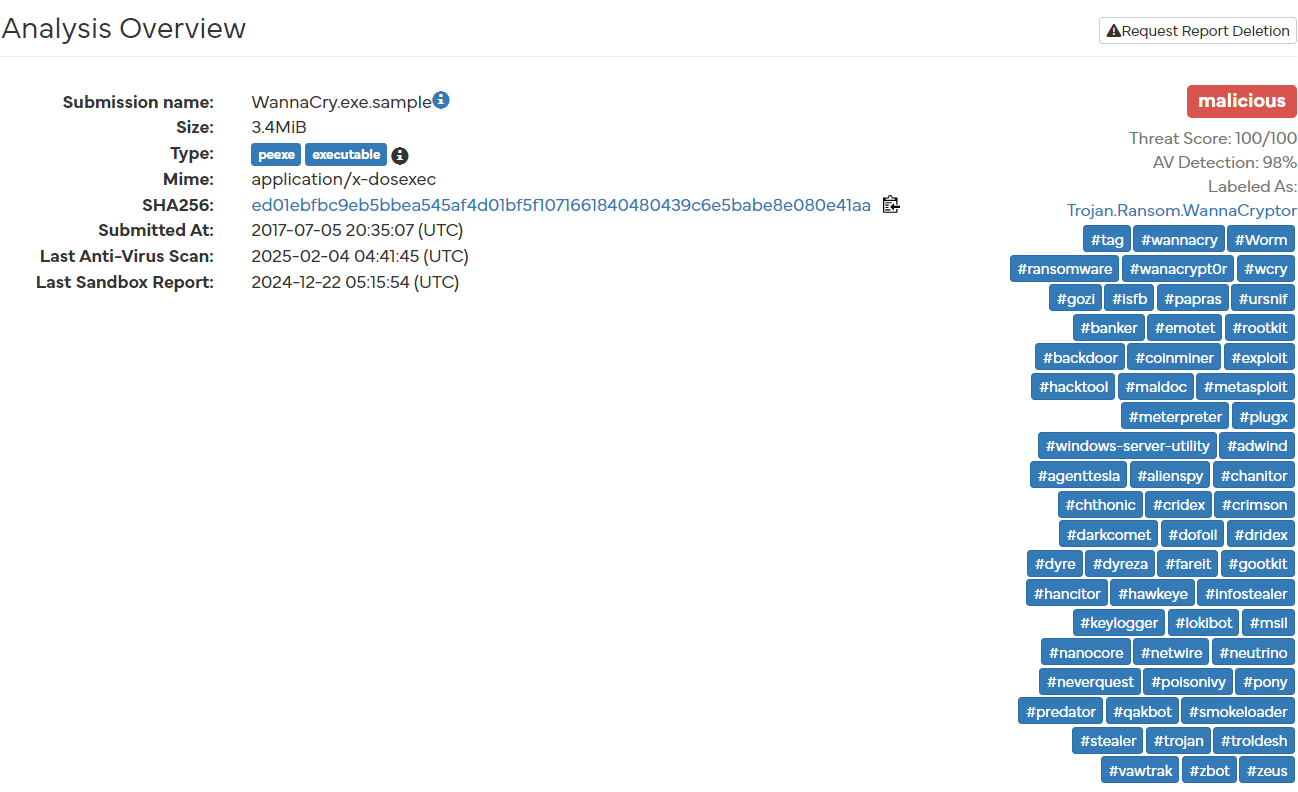

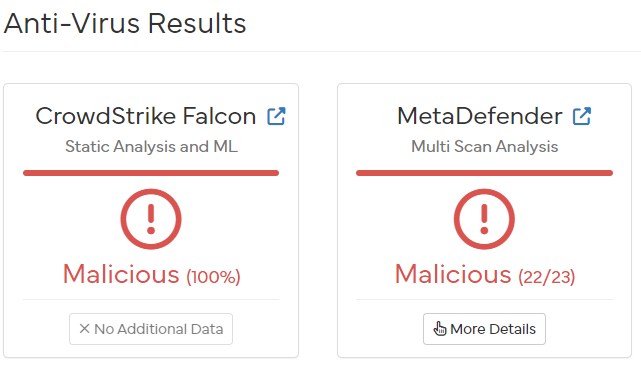

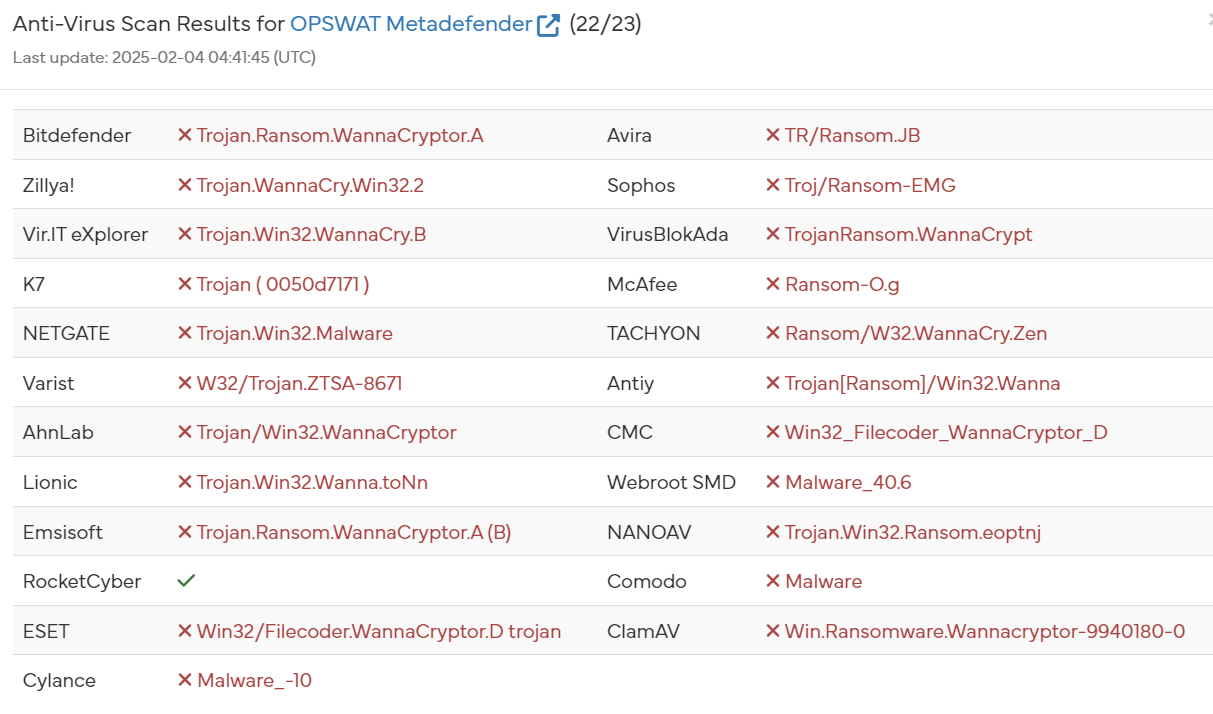

Pues parece que siempre sí era un ejecutable malicioso de nombre WannaCry.exe un ransomware. La página página indica múltiples reportes de varios Antivirus, solamente 1 no lo detectó como malicioso.
Por lo que considero que el ejecutable sí es malicioso, al mostrar que busca la manipulación de datos del ordenador. Esto con ayuda del uso de procesos y archivos nuevos, secuestrando ciertos datos del ordenador.

# sample_qwrty_dk2

## Análisis estático

In [25]:
headerAnalysis("sample_qwrty_dk2")

SECCIONES 	
b'UPX0\x00\x00\x00\x00' 0x1000 0x5000 0
b'UPX1\x00\x00\x00\x00' 0x6000 0x1000 4096
b'.rsrc\x00\x00\x00' 0x7000 0x1000 512
LLAMADAS A DLL 	
b'KERNEL32.DLL'
LLAMADAS A FUNCIONES 	
	 b'LoadLibraryA'
	 b'ExitProcess'
	 b'GetProcAddress'
	 b'VirtualProtect'
LLAMADAS A DLL 	
b'MSVCRT.dll'
LLAMADAS A FUNCIONES 	
	 b'atol'
LLAMADAS A DLL 	
b'SHELL32.dll'
LLAMADAS A FUNCIONES 	
	 b'SHChangeNotify'
LLAMADAS A DLL 	
b'USER32.dll'
LLAMADAS A FUNCIONES 	
	 b'LoadStringA'
LLAMADAS A DLL 	
b'WS2_32.dll'
LLAMADAS A FUNCIONES 	
	 b'closesocket'
TimeDateStamp : Thu May 14 17:12:40 2009 UTC


In [31]:
headerAnalysis("sample_qwrty_dk2_unpacked")

SECCIONES 	
b'.text\x00\x00\x00' 0x1000 0xea6 4096
b'.rdata\x00\x00' 0x2000 0x67e 2048
b'.data\x00\x00\x00' 0x3000 0x628 512
b'.rsrc\x00\x00\x00' 0x4000 0x80 512
LLAMADAS A DLL 	
b'KERNEL32.DLL'
LLAMADAS A FUNCIONES 	
	 b'CloseHandle'
	 b'WaitForSingleObject'
	 b'CreateEventA'
	 b'ExitThread'
	 b'Sleep'
	 b'GetComputerNameA'
	 b'CreatePipe'
	 b'DisconnectNamedPipe'
	 b'TerminateProcess'
	 b'WaitForMultipleObjects'
	 b'TerminateThread'
	 b'CreateThread'
	 b'CreateProcessA'
	 b'DuplicateHandle'
	 b'GetCurrentProcess'
	 b'ReadFile'
	 b'PeekNamedPipe'
	 b'SetEvent'
	 b'WriteFile'
	 b'SetProcessPriorityBoost'
	 b'SetThreadPriority'
	 b'GetCurrentThread'
	 b'SetPriorityClass'
	 b'lstrcatA'
	 b'lstrcpyA'
	 b'GetEnvironmentVariableA'
	 b'GetShortPathNameA'
	 b'GetModuleFileNameA'
	 b'GetStartupInfoA'
	 b'GetModuleHandleA'
LLAMADAS A DLL 	
b'MSVCRT.dll'
LLAMADAS A FUNCIONES 	
	 b'_controlfp'
	 b'_beginthread'
	 b'_strnicmp'
	 b'sprintf'
	 b'atol'
	 b'strchr'
	 b'free'
	 b'malloc'
	 b'_exit'
	 b

In [36]:
inverseEngineering("sample_qwrty_dk2")

pushal	
mov	esi, 0x406000
lea	edi, [esi - 0x5000]
push	edi
or	ebp, 0xffffffff
jmp	0x406dc2
nop	
nop	
nop	
nop	
nop	
nop	
mov	al, byte ptr [esi]
inc	esi
mov	byte ptr [edi], al
inc	edi
add	ebx, ebx
jne	0x406dc9
mov	ebx, dword ptr [esi]
sub	esi, -4
adc	ebx, ebx
jb	0x406db8
mov	eax, 1
add	ebx, ebx
jne	0x406ddb
mov	ebx, dword ptr [esi]
sub	esi, -4
adc	ebx, ebx
adc	eax, eax
add	ebx, ebx
jae	0x406dd0
jne	0x406dec
mov	ebx, dword ptr [esi]
sub	esi, -4
adc	ebx, ebx
jae	0x406dd0
xor	ecx, ecx
sub	eax, 3
jb	0x406e00
shl	eax, 8
mov	al, byte ptr [esi]
inc	esi
xor	eax, 0xffffffff
je	0x406e72
mov	ebp, eax
add	ebx, ebx
jne	0x406e0b
mov	ebx, dword ptr [esi]
sub	esi, -4
adc	ebx, ebx
adc	ecx, ecx
add	ebx, ebx
jne	0x406e18
mov	ebx, dword ptr [esi]
sub	esi, -4
adc	ebx, ebx
adc	ecx, ecx
jne	0x406e3c
inc	ecx
add	ebx, ebx
jne	0x406e28
mov	ebx, dword ptr [esi]
sub	esi, -4
adc	ebx, ebx
adc	ecx, ecx
add	ebx, ebx
jae	0x406e1d
jne	0x406e39
mov	ebx, dword ptr [esi]
sub	esi, -4
adc	ebx, ebx
jae	0x406e1d
add	ecx, 2
cmp

In [33]:
comparationTable3("sample_qwrty_dk2_unpacked")

process_hollowing:  0/7
create_remote_thread:  0/6
enumerating_all_processes:  0/4
drop_file_from_PE_resource_section:  0/4
IAT_hooking:  0/3
delete_itself:  0/3
download_and_execute_PE_file:  0/2
bind_TCP_port:  2/2
capture_network_traffic:  2/4
Total: 4


1. ¿Se encuentran empaquetados los ejecutable? ¿Cómo lo puede determinar? (en caso positivo, desempaquetelos)

Parece que sí, el ejecutable se encuentra empaquetado. Ya que las secciones que muestra tienen la nomenclatura UPXn. Además la línea de comando upx -t sample_qwrty_dk2 lanzó lo siguiente
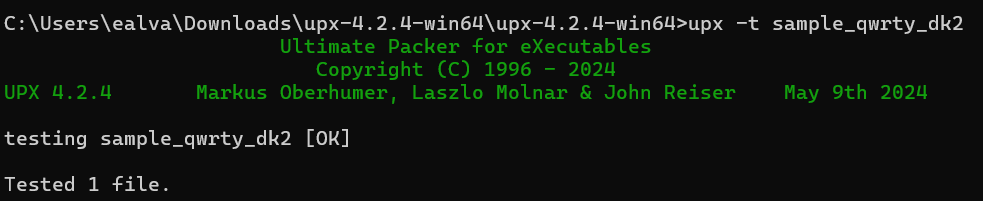

Se desempaquetó y se ejecutaron los demás análisis.
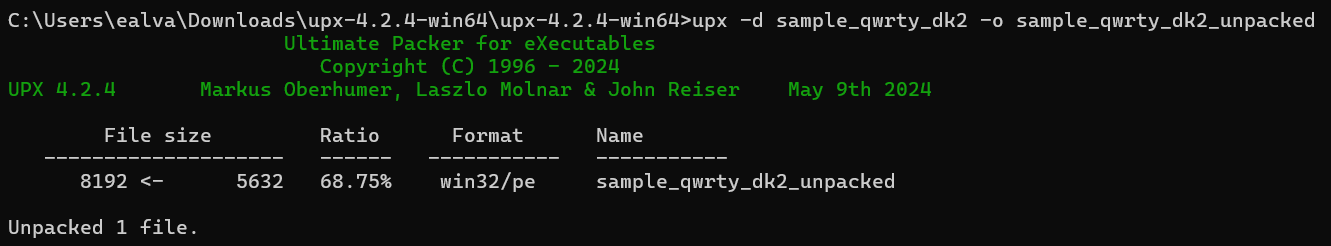


2. Muestra una lista de las DLLs y funciones utilizadas. Lea el artículo Descargar artículo"Malware classification based on API calls and behaviour analysis." Compare la tabla 3 contra las funciones de los ejecutables. ¿Hay indicios de algún comportamiento malicioso en base a la comparación? Justifique su respuesta.

Sí, considero que hay indicios de comportamiento malicioso. Aunque solamente son 4 de las llamadas maliciosas mostradas en la tabla 3 del artículo considero que esasa 4 son bastante delicadas. Ya que se trata del uso de puertos y sockets. Además de una captura del tráfico de la red a la que el ordenador está conectado.

3. ¿Cuándo fueron compilados los ejecutable?

Thu May 14 17:12:40 2009 UTC. Alrededor de las 11:12:40 en Guatemala

4. Obtenga el código ensamblador aplicando ingeniería inversa de ambos ejecutables

El código se muestra en la celda donde se hace el llamado a la función `inverseEngineering`. Aunque curiosamente solamente funcionó utilizando el ejecutable empaquetado, con el ejecutable desempaquetado no imprimía nada. 

## Análisis dinámico

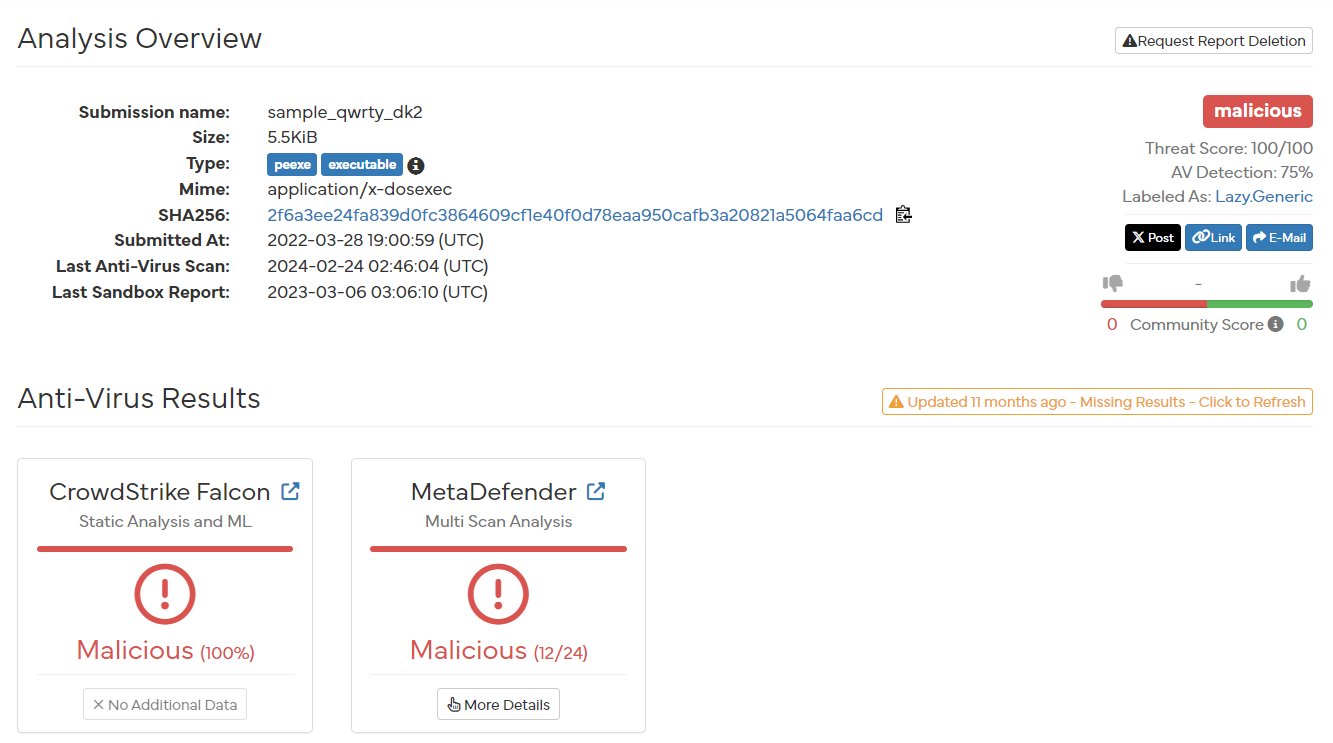

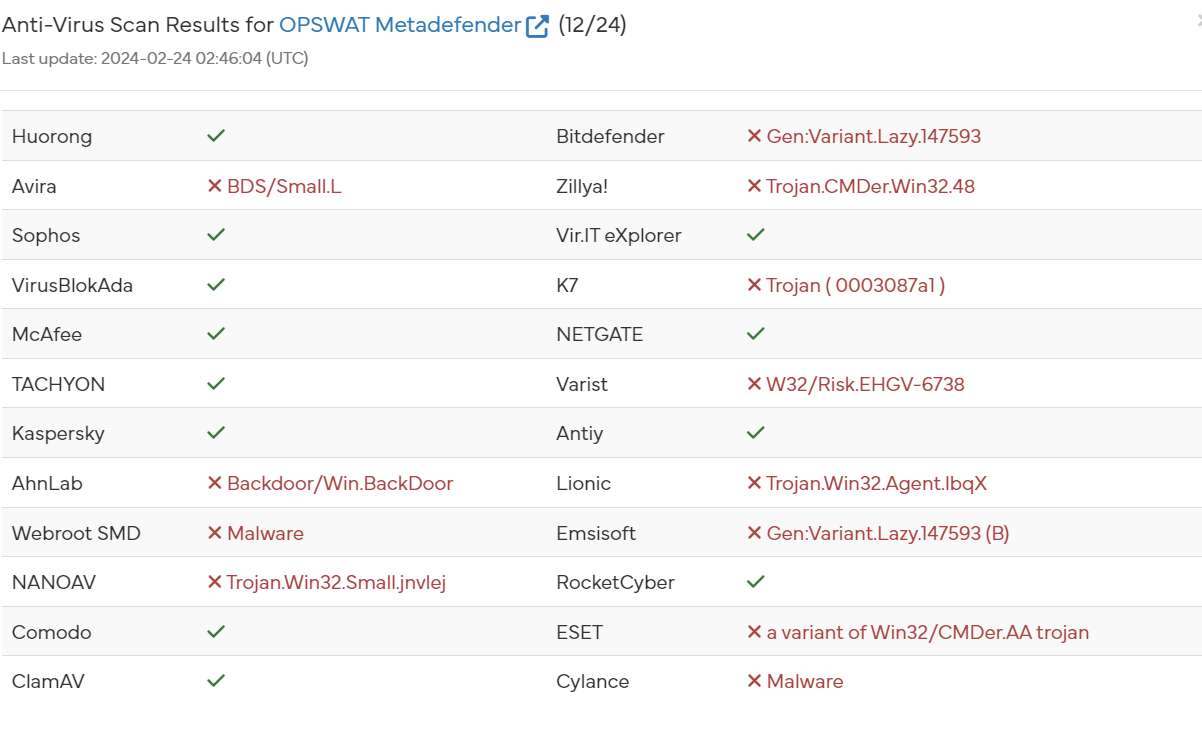

Sí, considero que es malicioso. Aunque a diferencia del anterior, este solo mostró ser malicioso para 12 antivirus creo que es más que suficiente para determinar que el ejecutable contiene malas intenciones en su uso. Y varios concluyeron en lo mismo, que son troyanos. Y por sus llamadas, coincido con la conclusión del antivirus AhnLab, el cuál dice que el ejecutable es un backdoor. Un espionaje al ordenador.